In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt

# London Crime Clustering

The purpose of this notebook is to examine the case of clusters of certain types of crime in London and to also advance my understanding of hierarchical clustering.

The theory is that given that 'birds of a feather flock together' then if different types of crime were examined in London then clusters of certain types of crime would appear geographically concentrated. For example, if one locality has a high proportion of knife crime then it would be thought that the locality next door would also be likely to have a high proportion of crime as well. Thus, if we were to identify certain types of clusters, then localities close together would naturally be expected to belong to the same cluster.



# Hierarchical clustering

Hierarchical clustering is part of the unsupervised learning models of machine learning. This means that we don't have a defined target variable unlike in regression or classification. The point of this machine learning algorithm therefore is to identify distinct custers of objects that share similar characteristics. Other machine learning algorithms that fit in with part of this family include kmeans, DBscan. 

This specific algorithm comes in two forms: top-down or bottom up. The first, top-down, starts treats all points as part of a single cluster and then gradually breaks them up into seperate clusters (divissive) until they are all part of their own cluster. The second, bottom-up, starts from the basis that all points are part of their own cluster and then groups the two closest points together, iteratively, until they are all part of a single cluster (Agglomerative). This hierarchy of clusters can be can be represnted as a tree (or a dendrogram) as below, the leaves representing individual clusters and distance increasing as go up the clusters. This can be visualised as:

<img src="files/Img/Hierarchical_Clus_den.png"> 

<img src="files/Img/Hierarchical_Clus_plt.png">

The most common form of this is the Agglomerative method. The outcome of this can be influenced by two main things: the distance method chosen (how the distance between points is calculated) and the linkage method chosen (between which points the distance is calculated). The different forms of this are as follows:

## Affinity [2](https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d) [3](https://www.analyticsvidhya.com/blog/2020/02/4-types-of-distance-metrics-in-machine-learning/)

These will also depend on the choice of distance metric (affinity) used as well:

### Euclidean (l2)

This is the default distance metric used to measure the distance between clusters and is simply the straight line distance between two points. This is mathematically expressed as:

$d(x,y) = \sqrt{\sum_i (x_i - y_i)^2}$

And visually represented as:

<img src="files/Img/euclid_dist.png">


### Manhattan (l1)

This distance is the sum of absolute difference between points across all the dimensions. This works as if there was grid like path between the points. This is mathematically expressed as:

$d(x,y) = \sum_{n=1} |x_i - y_i|$

And visually represented as:

<img src="files/Img/Manhat_dist.png">

This is also known as Taxicab Geometry and City Block Distance among others. This distance is often good for sparse features.

### Cosine

This distance metric measures the degree of angle between two vectores. This is used when the magnitude between points does not matter but the orientation does and is often used in natural language programming. This is measured as:

$\cos(\theta) = \frac{A \dot B}{||A||*||B||}$

### Precomputed

This is used if you already have a precomputed distance matrix for your observations.

The chosen metric aims to maximise the distance between samples in different classes and minimises the distance between each class [1](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)


## Linkage

The formation of these groups depends on the choice of different linkage metrics:

### Single/Min

This measures the similarity of two clusters as equal to the minimum of the similarity between the points closest to each other. Mathematically this is represented as:

Sim($C_1$, $C_2$) = Min Sim($P_i$, $P_j$) such that $P_i \in C_1$ & $P_j \in C_2$

And visually represented as:

<img src="files/Img/Min_dist.png">

The benefit of this measure is that it can deal with non-standard shapes of clusters, but cannot seperate clusters properly if there is noise.


### Complete/maximum 

This is the opposite to the minimum approach as the simialrity of the two clusters is equal to the maximum of the similarity between points within each of the clusters. This can be wriiten as:

Sim($C_1$, $C_2$) = Max Sim($P_i$, $P_j$) such that $P_i \in C_1$ & $P_j \in C_2$

And visually represented as:

<img src="files/Img/Max_dist.png">

This does well in seperating clusters if there is noise between them, but it is biased towards circular clusters and tends to break up large clusters.

### Average 

This linkage measure uses the average of the distances of all observations of the two sets. Mathematically this is represented as:

sim ($C_1$, $C_2$) = $\sum_{ij} (P_i, P_j)/|C_1|*|C_2|$

And visually represented as:

<img src="files/Img/avg_dist.png">

This does well in seperating clusters if tehre is noise between the clusters but is biased towards clusters that form blobs.

### Wards

This approach of calculating similarity between the two clusters is the same as group average, excpet this calculates the sum of squares of the distances $P_i$ and $P_j$. Essentiallt this minimises the variance of the clusters being merged. Mathematically this can be written as:

sim($C_1$, $C_2$) = $\sum (dist(P_i, P_j))^2/|C_1|*|C_2|$

And visually represented as:

<img src="files/Img/Wards_dist.png">

The benefits of this method is that it does well in seperating clusters if there is noise but it is biased towards circular groups of clusters.

The benefits of hierarchical clustering, in comparison to other methods of clustering, is that it does not need the number of clusters to be specified. Furthermore, the algorithm is not that sensitive to the distance metric. This is especially useful when the underlying data has a hierarchical structure or that is what we expect from the data. However, this comes at the cost of lower efficiency due to a time complxity of O(n³) and space complexity of O(n²). Furthermore there is no natural performance metric for hierarchical clustering to tell which number of clusters best fits the data, unlike with kmeans or DBscan.

[4](https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec)

[5](https://www.saedsayad.com/clustering_hierarchical.htm#:~:text=In%20average%20linkage%20hierarchical%20clustering,point%20in%20the%20other%20cluster.)

# Application of hierarchical clustering

The focus of this application will be on London crime data. Thus, data is extracted from the London Data store on crimes that occur at the LSOA level. This level is chosen because they represent the most standardised unit in terms of the number of households that were available. This reduces some potential variance that could have occured as a result of non-standard geographical units.

In [2]:
crime = pd.read_csv("https://data.london.gov.uk/download/recorded_crime_summary/644a9e0d-75a3-4c3a-91ad-03d2a7cb8f8e/MPS%20LSOA%20Level%20Crime%20%28most%20recent%2024%20months%29.csv")

Once the data has been loaded in we want to inspect the format that the data is in and how it could be cleaned for our purpose of clustering.

In [3]:
crime.head(10)

,LSOA Code,Borough,Major Category,Minor Category,201901,201902,201903,201904,201905,201906,...,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
0,E01000006,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,E01000007,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,E01000009,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E01000010,Barking and Dagenham,Arson and Criminal Damage,Arson,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,E01000013,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,E01000016,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
6,E01000017,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,E01000018,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8,E01000021,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
9,E01000023,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
crime.tail(10)

,LSOA Code,Borough,Major Category,Minor Category,201901,201902,201903,201904,201905,201906,...,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
103926,E01033599,Westminster,Violence Against the Person,Violence without Injury,2,2,4,1,2,0,...,2,2,2,2,4,3,1,5,2,3
103927,E01033600,Westminster,Violence Against the Person,Violence without Injury,3,1,0,1,1,0,...,0,1,0,4,2,2,0,0,2,1
103928,E01033601,Westminster,Violence Against the Person,Violence without Injury,0,4,2,1,9,0,...,2,0,3,1,5,1,3,2,4,3
103929,E01033602,Westminster,Violence Against the Person,Violence without Injury,2,1,4,3,1,1,...,3,4,1,1,2,0,6,4,7,1
103930,E01033603,Westminster,Violence Against the Person,Violence without Injury,2,0,2,1,2,4,...,2,2,6,2,10,2,2,2,6,3
103931,E01033604,Westminster,Violence Against the Person,Violence without Injury,2,5,3,7,5,7,...,7,3,4,7,4,5,4,12,4,8
103932,E01033605,Westminster,Violence Against the Person,Violence without Injury,2,3,5,7,2,1,...,1,5,4,4,5,4,4,5,2,4
103933,E01033606,Westminster,Violence Against the Person,Violence without Injury,1,0,1,1,1,3,...,2,1,1,1,0,0,4,2,0,0
103934,E01033607,Westminster,Violence Against the Person,Violence without Injury,2,4,1,1,1,1,...,0,1,3,1,2,3,0,1,2,2
103935,E01033608,Westminster,Violence Against the Person,Violence without Injury,1,1,1,0,0,1,...,0,3,0,2,0,2,2,2,2,1


In [5]:
crime.describe()

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,...,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
count,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,...,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.000000,103936.00000,103936.000000,103936.000000
mean,0.673780,0.656548,0.731835,0.690540,0.712342,0.707358,0.749519,0.702615,0.696862,0.747258,...,0.607470,0.452557,0.530750,0.575546,0.651257,0.652661,0.658194,0.65701,0.594116,0.550666
std,2.611658,3.054447,3.260499,3.197847,2.807630,2.761568,2.667297,2.504590,2.536981,2.890493,...,1.993407,1.069536,1.220003,1.327082,1.661642,1.802906,1.788529,1.83801,1.394059,1.581381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,255.000000,479.000000,464.000000,391.000000,306.000000,250.000000,226.000000,218.000000,270.000000,307.000000,...,196.000000,60.000000,67.000000,72.000000,104.000000,141.000000,125.000000,129.00000,53.000000,140.000000


In [6]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103936 entries, 0 to 103935
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA Code       103936 non-null  object
 1   Borough         103936 non-null  object
 2   Major Category  103936 non-null  object
 3   Minor Category  103936 non-null  object
 4   201901          103936 non-null  int64 
 5   201902          103936 non-null  int64 
 6   201903          103936 non-null  int64 
 7   201904          103936 non-null  int64 
 8   201905          103936 non-null  int64 
 9   201906          103936 non-null  int64 
 10  201907          103936 non-null  int64 
 11  201908          103936 non-null  int64 
 12  201909          103936 non-null  int64 
 13  201910          103936 non-null  int64 
 14  201911          103936 non-null  int64 
 15  201912          103936 non-null  int64 
 16  202001          103936 non-null  int64 
 17  202002          103936 non-nu

After inspection we can take away three things:
1. Firstly that there are 103,936 observations that are all non-null values. This means that data cleanup should be relatively easily as there are no nan values that woll have to be dealth with or inspected.
2. The data is split into months for 2019 and 2020. This means we could take a look at individual months in terms of crime data, or if we want to look at a single year then the data would have to be aggregated.
3. There are major types of crime and minor types of crime. These minor types of crime are subsets of each major type of crime category.

For our purpuse, 1 means that data cleaning is relatively simple, 2 means that since we want to focus on a single year the data needs to be aggreagted, but 3 warrants further inspection, which can be done by extracting the unique values of major and minor crime and see how they link.

In [7]:
#we can firstly extract the unique values to see what they are:
major_cats = crime["Major Category"].unique()
minor_cats = crime["Minor Category"].unique()

print(major_cats)
print(minor_cats)

['Arson and Criminal Damage' 'Burglary' 'Drug Offences'
 'Miscellaneous Crimes Against Society' 'Possession of Weapons'
 'Public Order Offences' 'Robbery' 'Theft' 'Vehicle Offences'
 'Violence Against the Person']
['Arson' 'Criminal Damage' 'Burglary - Business and Community'
 'Burglary - Residential' 'Drug Trafficking' 'Possession of Drugs'
 'Bail Offences' 'Bigamy' 'Dangerous Driving'
 'Disclosure, Obstruction, False or Misleading State'
 'Exploitation of Prostitution'
 'Fraud or Forgery Associated with Driver Records'
 'Going Equipped for Stealing' 'Handling Stolen Goods'
 'Making, Supplying or Possessing Articles for use i'
 'Obscene Publications' 'Other Forgery' 'Other Notifiable Offences'
 'Perjury' 'Perverting Course of Justice' 'Possession of False Documents'
 'Profitting From or Concealing Proceeds of Crime'
 'Threat or Possession With Intent to Commit Crimina' 'Wildlife Crime'
 'Other Firearm Offences' 'Possession of Article with Blade or Point'
 'Possession of Firearm with I

In [8]:
#we can then see how they group i.e. are minor crime specific subsets or are they seperate groups
crime_type = crime.groupby(["Major Category", "Minor Category"]).agg({"LSOA Code":"count"})
crime_type

LSOA Code
Major Category                       Minor Category                                               
Arson and Criminal Damage            Arson                                                    2081
                                     Criminal Damage                                          4826
Burglary                             Burglary - Business and Community                        4072
                                     Burglary - Residential                                   4829
Drug Offences                        Drug Trafficking                                         2880
                                     Possession of Drugs                                      4745
Miscellaneous Crimes Against Society Absconding from Lawful Custody                             51
                                     Bail Offences                                              92
                                     Bigamy                                                     28
                                     Concealing an Infant Death Close to Birth                   1
                                     Dangerous Driving                                         652
                                     Disclosure, Obstruction, False or Misleading State         78
                                     Exploitation of Prostitution                               40
                                     Forgery or Use of Drug Prescription                        80
                                     Fraud or Forgery Associated with Driver Records           173
                                     Going Equipped for Stealing                               752
                                     Handling Stolen Goods                                     965
                                     Making, Supplying or Possessing Articles for use i        652
                                     Obscene Publications                                     2905
                                     Offender Management Act                                    29
                                     Other Forgery                                             890
                                     Other Notifiable Offences                                1066
                                     Perjury                                                    11
                                     Perverting Course of Justice                              890
                                     Possession of False Documents                             426
                                     Profitting From or Concealing Proceeds of Crime           661
                                     Soliciting for Prostitution                                23
                                     Threat or Possession With Intent to Commit Crimina       2510
                                     Wildlife Crime                                              8
Possession of Weapons                Other Firearm Offences                                     85
                                     Possession of Article with Blade or Point                2616
                                     Possession of Firearm with Intent                         575
                                     Possession of Firearms Offences                           945
                                     Possession of Other Weapon                               2537
Public Order Offences                Other Offences Against the State, or Public Order        3640
                                     Public Fear Alarm or Distress                            4784
                                     Racially or Religiously Aggravated Public Fear, Al       4112
                                     Violent Disorder                                          118
Robbery                              Robbery of Business Property                             1854
                              

What this shows is that there are a large number of minor crimes, while there is only 10 major crime categories. these minor crimes are also specific subsets of each major crime (there appears no overlap in minor catgeries within each major category). If we were to focus on the large number of minor categories our clusters may be difficult to interpret because of the variability in terms of the number of LSOAs within each category and the high dimensionality of the data that would result of using many features. Therefore, the focus of this is on the Major categories as that is what we are interested in and should lead to greater intepretability.

We could also see that from above the columns are for each month in 2019 and 2020. Our interest here is identify crime clusters over a single year, and since 2020 was the year of covid, we want to inspect the year 2019 first. For this we have to sum all columns from each year into a single column as we do below:

In [9]:
cols_to_sum_19 = [col for col in crime.columns if "2019" in str(col)]
cols_to_sum_20 = [col for col in crime.columns if "2020" in str(col)]

crime["2019"] = crime[cols_to_sum_19].sum(axis = 1)
crime["2020"] = crime[cols_to_sum_20].sum(axis = 1)

We can then extract only the data that we need in terms of each LSOA, Major cateory, 2019 and 2020.

In [10]:
crime = crime[["LSOA Code", "Major Category", "2019", "2020"]]
crime

,LSOA Code,Major Category,2019,2020
0,E01000006,Arson and Criminal Damage,1,2
1,E01000007,Arson and Criminal Damage,0,1
2,E01000009,Arson and Criminal Damage,2,0
3,E01000010,Arson and Criminal Damage,4,0
4,E01000013,Arson and Criminal Damage,0,1
...,...,...,...,...
103931,E01033604,Violence Against the Person,61,75
103932,E01033605,Violence Against the Person,49,44
103933,E01033606,Violence Against the Person,13,14
103934,E01033607,Violence Against the Person,20,16


To make sure that this has been done correctly, we can examine some LSOA values.

In [11]:
crime[crime["LSOA Code"] == "E01000006"]

,LSOA Code,Major Category,2019,2020
0,E01000006,Arson and Criminal Damage,1,2
64,E01000006,Arson and Criminal Damage,6,4
254,E01000006,Burglary,13,5
364,E01000006,Drug Offences,0,1
445,E01000006,Drug Offences,6,24
653,E01000006,Miscellaneous Crimes Against Society,3,1
771,E01000006,Miscellaneous Crimes Against Society,1,0
1111,E01000006,Public Order Offences,2,0
1204,E01000006,Public Order Offences,3,0
1314,E01000006,Public Order Offences,0,3


We can see here that there are multiple entries for each Major category, and this will be a result of the different minor categories within each major categories. Consequently, we need to further aggregate these results, summing over each major category. 

Before we do this however we also want to subset this into 2019 and so we can drop the 2020 column from the dataset, while retaining the previous dataset.

In [12]:
#drop the 2019 column but do so iin creating a new 2019 labelled dataframe
crime_2019 = crime.drop(columns = ["2020"]).copy()

Then, to get the data into the correct format and aggregate across the major categories, since we currently have the data in a single column, which restricts our ability to run the cluster on multiple columns, we want to transform the data from a single column containing values for each LSOA and each Major crime category, into rows containing all data for a single LSOA across each Major crime Category. This can be done using the pivot table function while aggregating across the Major category column:

In [13]:
#use the pivot table function, set index to LSOA, column names to be the major categories, and values from the 2019 column
#we want to agg by the sum and we want to fill any empty values with a zero
crime_2019 = crime_2019.pivot_table(index= 'LSOA Code', columns = 'Major Category', 
                                    values = "2019", aggfunc = np.sum,
                                    fill_value = 0).reset_index()
#then rename the axis
crime_2019.rename_axis(None,axis=1, inplace=True)

A total crime column should also be created, as if we focused on the absolute number of crimes then there would be come types of crime that have greater variation and thus the clustering algorithm may focus on this result and the outputs may be difficult to interpret. Thus, a total column is created, with each crime type divided by the total amount of crime so that we get the percentage of crime that occurs within an area of that category, rather than focusing on areas that may have relatively high absolute levels of crime.

In [14]:
#extract the columns to sum
cols_to_sum = [col for col in crime_2019.columns if "LSOA" not in col]
#sum across the columns rather than rows
crime_2019["Total_crime"] = crime_2019[cols_to_sum].sum(axis=1)

In [15]:
#we then want to turn the previous columns into percentages
#do this by dividing over the total crime columns
for col in cols_to_sum:
    crime_2019[col] = crime_2019[col]/crime_2019["Total_crime"]

The results can then be inspected to make sure that the data cleaning has achieved the desired objective:

In [16]:
crime_2019

,LSOA Code,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Theft,Vehicle Offences,Violence Against the Person,Total_crime
0,E01000006,0.064220,0.119266,0.055046,0.036697,0.000000,0.045872,0.100917,0.064220,0.128440,0.385321,109
1,E01000007,0.040462,0.038536,0.129094,0.011561,0.009634,0.055877,0.111753,0.289017,0.061657,0.252408,519
2,E01000008,0.068182,0.077273,0.072727,0.013636,0.000000,0.063636,0.031818,0.250000,0.186364,0.236364,220
3,E01000009,0.051852,0.051852,0.088889,0.007407,0.003704,0.059259,0.114815,0.244444,0.074074,0.303704,270
4,E01000010,0.040802,0.035270,0.075380,0.008299,0.012448,0.051176,0.064315,0.456432,0.057400,0.198479,1446
...,...,...,...,...,...,...,...,...,...,...,...,...
4824,E01033742,0.102041,0.061224,0.040816,0.000000,0.000000,0.020408,0.020408,0.122449,0.367347,0.265306,49
4825,E01033743,0.045198,0.022599,0.014124,0.005650,0.002825,0.036723,0.011299,0.587571,0.087571,0.186441,354
4826,E01033744,0.107143,0.064286,0.021429,0.000000,0.000000,0.071429,0.014286,0.071429,0.221429,0.428571,140
4827,E01033745,0.143836,0.095890,0.047945,0.013699,0.006849,0.034247,0.027397,0.116438,0.205479,0.308219,146


In [17]:
crime_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4829 entries, 0 to 4828
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   LSOA Code                             4829 non-null   object 
 1   Arson and Criminal Damage             4829 non-null   float64
 2   Burglary                              4829 non-null   float64
 3   Drug Offences                         4829 non-null   float64
 4   Miscellaneous Crimes Against Society  4829 non-null   float64
 5   Possession of Weapons                 4829 non-null   float64
 6   Public Order Offences                 4829 non-null   float64
 7   Robbery                               4829 non-null   float64
 8   Theft                                 4829 non-null   float64
 9   Vehicle Offences                      4829 non-null   float64
 10  Violence Against the Person           4829 non-null   float64
 11  Total_crime      

In [18]:
crime_2019.describe()

,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Theft,Vehicle Offences,Violence Against the Person,Total_crime
count,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000
mean,0.074477,0.117422,0.050805,0.012781,0.007869,0.057008,0.038084,0.175691,0.189143,0.276720,182.760199
std,0.036388,0.060916,0.039835,0.014725,0.009290,0.029002,0.029559,0.122368,0.095509,0.092306,316.020157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008403,0.029851,15.000000
25%,0.048780,0.074468,0.023377,0.002375,0.000000,0.037037,0.017964,0.090164,0.120000,0.212121,87.000000
50%,0.068966,0.106061,0.042802,0.010204,0.006061,0.054688,0.033333,0.141176,0.173913,0.274611,123.000000
75%,0.094595,0.147887,0.068966,0.018182,0.012579,0.074510,0.052632,0.224199,0.243902,0.337931,188.000000
max,0.333333,0.523810,0.532051,0.371429,0.075472,0.205882,0.281690,0.752637,0.616541,0.761092,9437.000000


Once we have confirmed the data is in the correct format, we can then see how it looks when it has been mapped:

In [19]:
#load in the LSOA map 
UK_LSOA = gpd.read_file("https://opendata.arcgis.com/datasets/1f23484eafea45f98485ef816e4fee2d_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D")
#extract only the necessary information
UK_LSOA = UK_LSOA[["LSOA11CD", "geometry"]]

In [20]:
#merge the crime data with the LSOA file to create the London-crime dataframe
London_crime = UK_LSOA.merge(crime_2019, left_on = "LSOA11CD", right_on = "LSOA Code", how = "right")

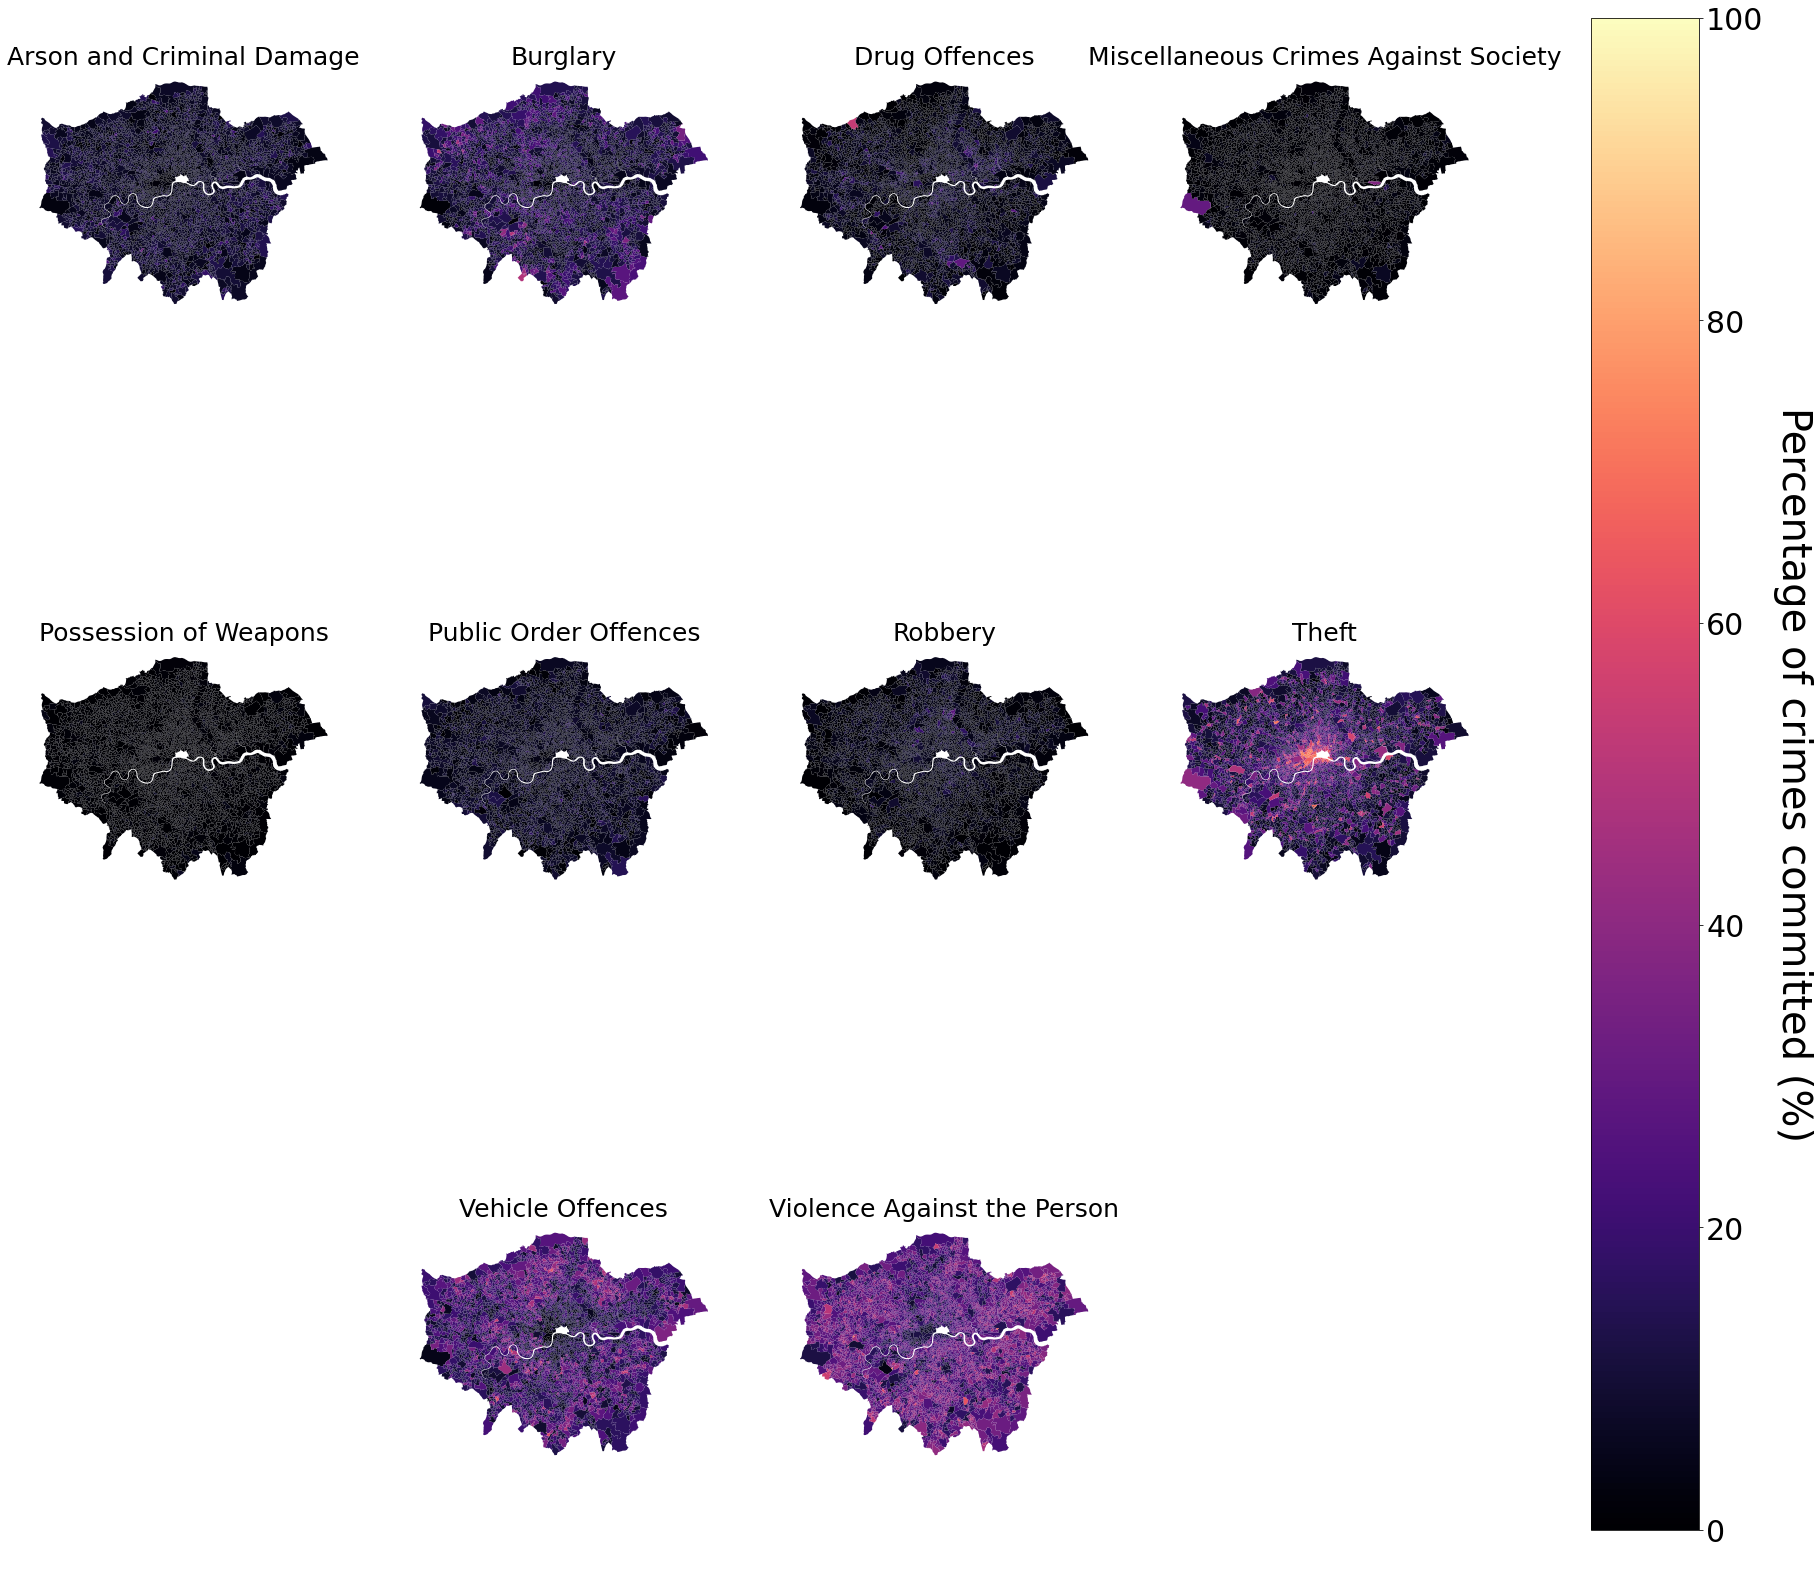

In [21]:
#we then want to map the result

#extract the columns that we don't want to plot
not_plot = ["LSOA11CD", "geometry", "LSOA Code", "Total_crime"]
#use this to extract the columns that we do want to plot
to_plot = [col for col in London_crime.columns if col not in not_plot]

#print(to_plot)

#create a subplot axis, given that we have 10 different categories this has to be a 3 by 4 matrix of plots
fig, axis = plt.subplots(3,4, figsize = (30,30))
#flatten the axis so that we can iterate over them
axis = axis.flatten()

#creating the plot function
#use the enumerate to get the value and its index
for i, col in enumerate(to_plot):
    #set the axis as in the rows
    ax = axis[i]
    #to make it cleaner move two axis across
    if i >=8:
        ax = axis[i+1]
    #plot the crime map using the magma color map
    crim_plt = London_crime.plot(column = col, ax=ax, cmap = "magma", vmin =0, vmax = 1)
    #remove the axis so that it looks cleaner
    ax.set_axis_off()
    #set the plot title as the column name
    ax.set_title(col, fontsize = 25)

    
#plt.subplots_adjust(right = 0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cbar = plt.colorbar(cax=cbar_ax)

#adding a color bar for the overall plto
#https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
vmin, vmax = 0,100

#create a subaxis within the figure
fig = ax.get_figure()
plt.subplots_adjust(right = 0.8)
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7], label = "Percentage of crime")
#create a colorbar and plot it
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = fig.colorbar(sm, cax=cax)
#change the size of the tick parameters
cb.ax.tick_params(labelsize = 30)
#set the label title
#https://stackoverflow.com/questions/17475619/how-do-i-adjust-offset-colorbar-title-in-matplotlib
cb.set_label("Percentage of crimes committed (%)", rotation = 270, fontsize= 40, labelpad = 50)
#
#cax.tight_layout()

#remove axis of plots not covered
axis[8].set_axis_off()
axis[11].set_axis_off()
#show the results
plt.show()

What this plot tells us is that four main categories of: Bulgrary, Theft, Vehcile Offences and Violence against the person appear to have the greatest variance in values and also the larget values in terms of percentages. What this could mean is that the clustering algorithm may be likely to focus on these four factors because of this. However, since we are concerned with identifying clusters that are dominated by a type of crime, any further standardising/normalising may remove valuable information that we are interested in. Thus, this variance is accepted at the current momement and may be inspected in terms of how the clusters trun out latter.

Therefore, now that we have seen the results spatially, we can attempt to cluster the results to see how the clusters develop:

In [22]:
#import the necessary module
from sklearn.cluster import AgglomerativeClustering

In [23]:
#extract the values that we want to plot
crime_clus = London_crime[to_plot]

In [24]:
#create the model that we want, setting the linkage to ward, the distance threshold to 4 and 
#set the number of clusters to none so that we can plot the dendrogram afterwards
model = AgglomerativeClustering(linkage="ward", distance_threshold = 4, n_clusters=None)
#fit the model to the data
model.fit(crime_clus)

AgglomerativeClustering(distance_threshold=4, n_clusters=None)

Once the model has been fit to the data we want actually visualise the results in how this maps onto London. So the first thing we do is extract the labels and add them to our original dataframe.

In [25]:
London_crime["Aggl_clus"] = model.labels_

We can then plot the results in terms of London.

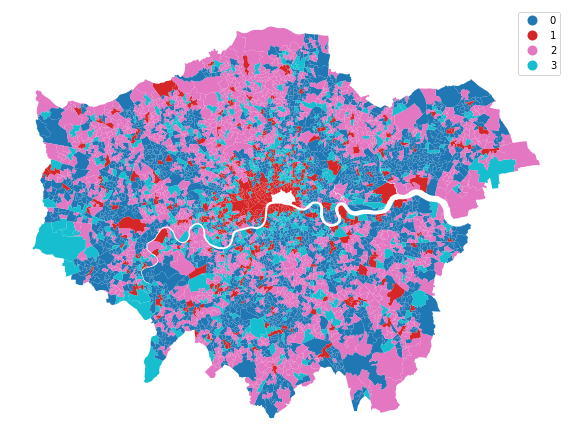

In [26]:
fig, ax = plt.subplots(figsize = (10,10))

London_crime.plot(column = "Aggl_clus", categorical = True, legend=True, ax=ax)
ax.set_axis_off()

What we can see here is that with the distance threshold set to 4 we get 4 clusters which are distributed across London. What is appears like from this inspection is that clsuter 1 is dominant in the centre of London but there are small patches across the rest of London. Cluster 2 tends to group together in the outer edges of London, while cluster 0 and 3 tend to be randomly distributed across London.

What we need to know next then is what do these clusters mean and how do they compare to each other in terms of the percenatges of crime between each cluster. This can be done by visualising the means of each of these clusters (although the distribution of clusters could also be used) which would allow us to assign labels to interpret each of these clusters:


In [27]:
agglom_means =London_crime.groupby("Aggl_clus")[to_plot].mean()
agglom_means_T = agglom_means.T.round(3)

#agglom_means_T.reset_index(inplace=True)
agglom_means_T = pd.DataFrame(agglom_means_T)
agglom_means_T

Aggl_clus,0,1,2,3
Arson and Criminal Damage,0.087,0.042,0.072,0.062
Burglary,0.097,0.074,0.161,0.103
Drug Offences,0.065,0.039,0.035,0.053
Miscellaneous Crimes Against Society,0.015,0.008,0.012,0.011
Possession of Weapons,0.010,0.006,0.006,0.008
Public Order Offences,0.064,0.056,0.046,0.061
Robbery,0.039,0.046,0.032,0.047
Theft,0.136,0.465,0.107,0.279
Vehicle Offences,0.145,0.089,0.284,0.158
Violence Against the Person,0.343,0.174,0.245,0.216


In [28]:
agglom_means_T

Aggl_clus,0,1,2,3
Arson and Criminal Damage,0.087,0.042,0.072,0.062
Burglary,0.097,0.074,0.161,0.103
Drug Offences,0.065,0.039,0.035,0.053
Miscellaneous Crimes Against Society,0.015,0.008,0.012,0.011
Possession of Weapons,0.010,0.006,0.006,0.008
Public Order Offences,0.064,0.056,0.046,0.061
Robbery,0.039,0.046,0.032,0.047
Theft,0.136,0.465,0.107,0.279
Vehicle Offences,0.145,0.089,0.284,0.158
Violence Against the Person,0.343,0.174,0.245,0.216


C:\Users\phili\anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


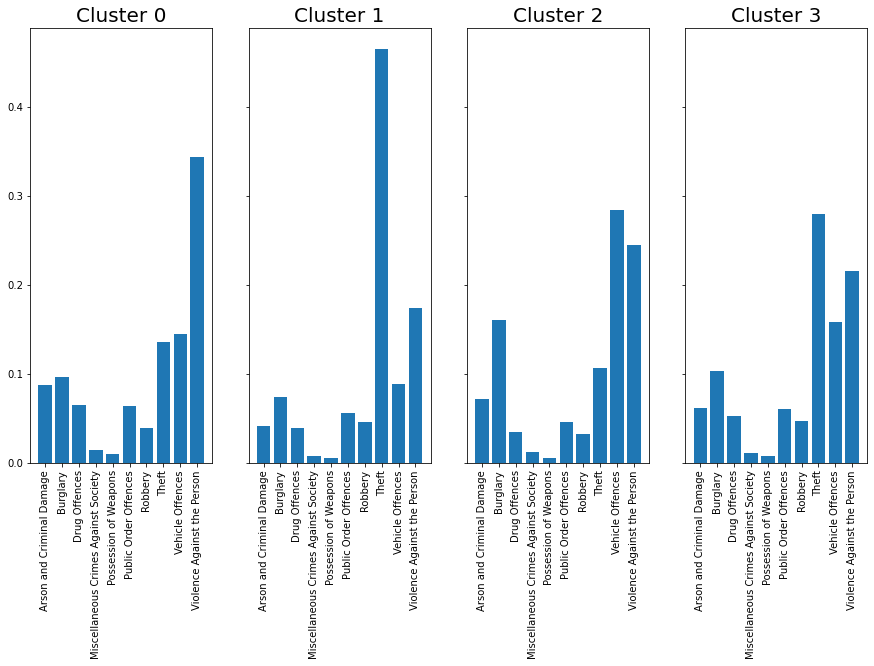

In [29]:
agglom_means_T.reset_index(inplace=True)

fig, ax = plt.subplots(1,4, figsize = (15,8), sharey = True, sharex = True)
axis = ax.flatten()
for i, col  in enumerate(agglom_means_T.columns):
    if col != "index":
        ax = axis[i-1]
        ax.bar(height = agglom_means_T[col], x=agglom_means_T["index"])
        ax.set_xticklabels(labels =agglom_means_T["index"], rotation = 90)
        ax.set_title(f"Cluster {col}", fontsize = 20)

From this we can see that Cluster 0 on average has relatively high Violence against the person, Arson and Criminal Damage and Drug offences compared to the other clusters. Cluster 1 is dominated by incidences of Theft, much more so than any of the other clusters but has relatively low violence against the person. Cluster 2 is dominated by instances of vehicle offences and violence against the person and a relatively high burglarly rate, while cluster 3 has the second highest theft rate, while also having the second highest incidenence of vehicle offences and Violence against the person.

Based on this therefore we could assign labels such that:

Cluster 0 - Violence against the person<br>
Cluster 1 - Theft <br>
Cluster 2 - Vehicle offences and Burglarly<br>
Cluster 3 - Theft and Violence against the person<br>

This labelling suggests some degree of overlap between cluster 0, 1 and 3 potentially. We can explore this further by examining the sizes of the clusters and how these play out.

In [30]:
agglom_sizes = London_crime.groupby("Aggl_clus").size()
agglom_sizes

Aggl_clus
0    2083
1     441
2    1644
3     661
dtype: int64

From this we can see that cluster 1 and 3 are much smaller than 0 or 2 (in the case of cluster 0 and 1 cluster 1 is 1/4 of the size of the cluster), which could suggest that this is not the optimal clustering.

Given that this is hierarchical clustering, we can aim to see how the model has behaved using the dendrogram. This shows the hierarchical structure in terms of how the model behaves and can be done using the following code:

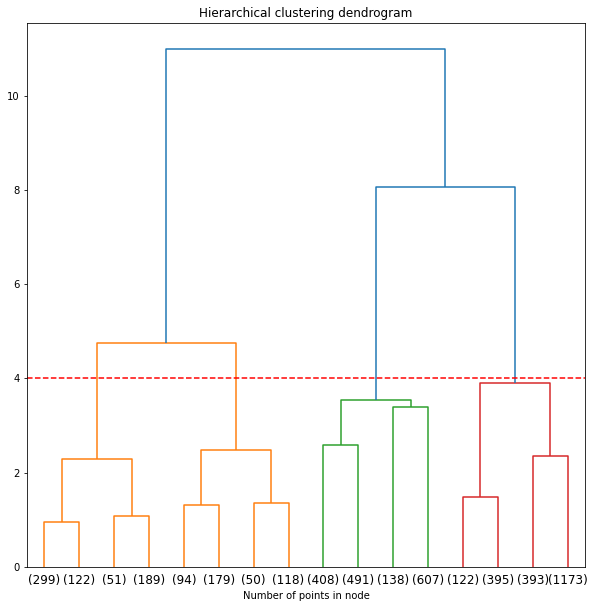

In [31]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.axhline(y = 4, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

What this shows is that with the current distance measure we get the four clusters, however we can see that at a slightly greater that two clusters merge and then moves into three clusters. This would suggest that cluster 1 and 3 would be better merging. At this point, the large distance until we see clusters merge again suggests that these clusters are relatively more stable. Thus, we can change the distance metric to a distance threshold of 6, which we can get three clusters and explore this again. We could also look at this the other way and reduce the cluster distance to 3 and split up to tho largest clusters while keeping the two smaller clusters are relatively the same size. Seen on the dendrogam this shows up as:

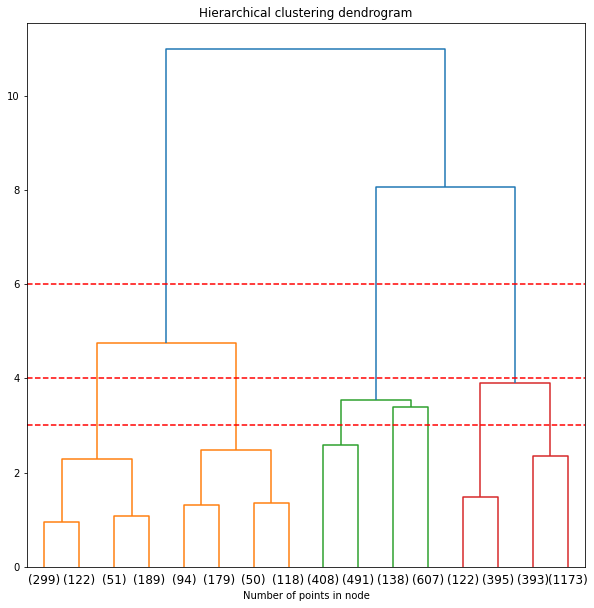

In [32]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.axhline(y = 4, color = "r", linestyle = "--")
plt.axhline(y = 6, color = "r", linestyle = "--")
plt.axhline(y = 3, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

Thus we can follow the same workflow as the previous clustering to see how the clusters look when we have a distance metric of 6 and 3:

In [33]:
#create the model that we want, setting the linkage to ward, the distance threshold to 4 and 
#set the number of clusters to none so that we can plot the dendrogram afterwards
model = AgglomerativeClustering(linkage="ward", distance_threshold = 6, n_clusters=None)
#fit the model to the data
model.fit(crime_clus)

AgglomerativeClustering(distance_threshold=6, n_clusters=None)

In [34]:
London_crime["Aggl_clus_3"] = model.labels_

In [35]:
#create the model that we want, setting the linkage to ward, the distance threshold to 4 and 
#set the number of clusters to none so that we can plot the dendrogram afterwards
model = AgglomerativeClustering(linkage="ward", distance_threshold = 3, n_clusters=None)
#fit the model to the data
model.fit(crime_clus)

AgglomerativeClustering(distance_threshold=3, n_clusters=None)

In [36]:
London_crime["Aggl_clus_7"] = model.labels_

Text(0.5, 1.0, 'Distance threshold 3 cluster')

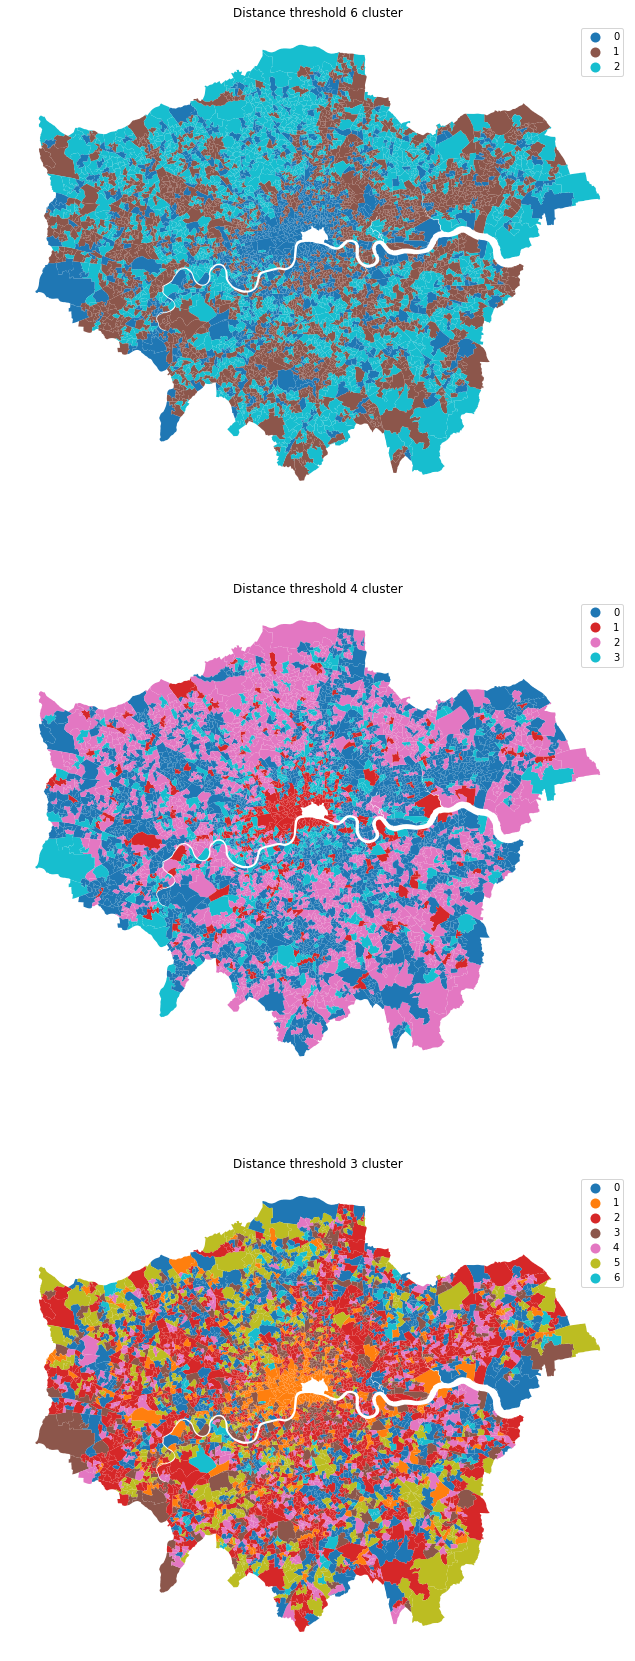

In [37]:
fig, ax = plt.subplots(3, 1, figsize = (15,30))

London_crime.plot(column = "Aggl_clus_3", categorical = True, legend=True, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title("Distance threshold 6 cluster")

London_crime.plot(column = "Aggl_clus", categorical = True, legend=True, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title("Distance threshold 4 cluster")

London_crime.plot(column = "Aggl_clus_7", categorical = True, legend=True, ax=ax[2])
ax[2].set_axis_off()
ax[2].set_title("Distance threshold 3 cluster")

C:\Users\phili\anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 0.98, 'Clusters with distance threshold 6')

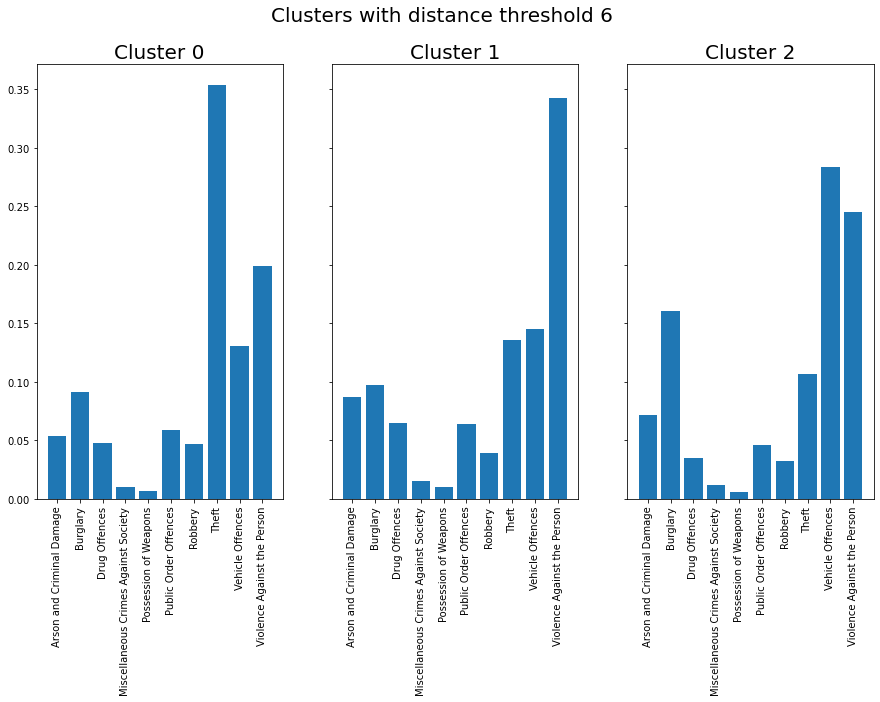

In [38]:
agglom_means =London_crime.groupby("Aggl_clus_3")[to_plot].mean()
agglom_means_T = agglom_means.T.round(3)

agglom_means_T = pd.DataFrame(agglom_means_T)

agglom_means_T.reset_index(inplace=True)

fig, ax = plt.subplots(1,3, figsize = (15,8), sharey = True, sharex = True)
axis = ax.flatten()
for i, col  in enumerate(agglom_means_T.columns):
    if col != "index":
        ax = axis[i-1]
        ax.bar(height = agglom_means_T[col], x=agglom_means_T["index"])
        ax.set_xticklabels(labels =agglom_means_T["index"], rotation = 90)
        ax.set_title(f"Cluster {col}", fontsize = 20)
        
plt.suptitle("Clusters with distance threshold 6", fontsize = 20)

In [39]:
agglom_sizes = London_crime.groupby("Aggl_clus_3").size()
agglom_sizes

Aggl_clus_3
0    1102
1    2083
2    1644
dtype: int64

C:\Users\phili\anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 0.98, 'Clusters with distance threshold 3')

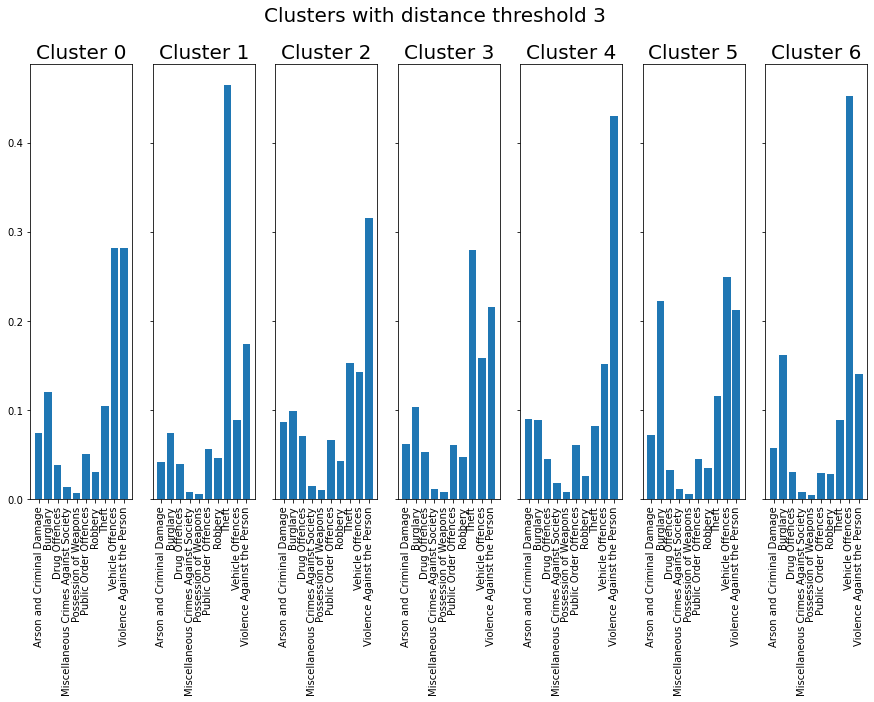

In [40]:
agglom_means =London_crime.groupby("Aggl_clus_7")[to_plot].mean()
agglom_means_T = agglom_means.T.round(3)

agglom_means_T = pd.DataFrame(agglom_means_T)

agglom_means_T.reset_index(inplace=True)

fig, ax = plt.subplots(1,7, figsize = (15,8), sharey = True, sharex = True)
axis = ax.flatten()
for i, col  in enumerate(agglom_means_T.columns):
    if col != "index":
        ax = axis[i-1]
        ax.bar(height = agglom_means_T[col], x=agglom_means_T["index"])
        ax.set_xticklabels(labels =agglom_means_T["index"], rotation = 90)
        ax.set_title(f"Cluster {col}", fontsize = 20)
        
plt.suptitle("Clusters with distance threshold 3", fontsize = 20)

Text(0.5, 1.0, 'Clusters with distance threshold 3')

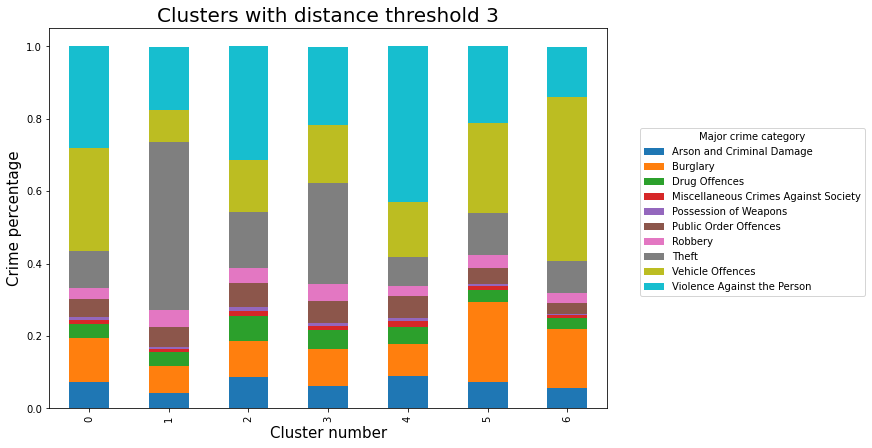

In [47]:
agglom_means =London_crime.groupby("Aggl_clus_7")[to_plot].mean()
agglom_means_T = agglom_means.T.round(3)

agglom_means_T = pd.DataFrame(agglom_means_T)

agglom_means_T.reset_index(inplace=True)

agglom_means_T.set_index('index', inplace=True)
agglom_means_T.rename_axis(None,axis=1, inplace=True)
agglom_means_T.T

fig, ax = plt.subplots(figsize = (10,10))

agglom_plot = agglom_means_T.T.plot.bar(stacked=True, figsize=(10,7), ax=ax)
agglom_plot.legend(title='Major crime category', bbox_to_anchor=(1.05, 0.75), loc='upper left')
ax.set_xlabel("Cluster number", fontsize = 15)
ax.set_ylabel("Crime percentage", fontsize = 15)
ax.set_title("Clusters with distance threshold 3", fontsize = 20)

In [ ]:
agglom_sizes = London_crime.groupby("Aggl_clus_7").size()
agglom_sizes

From this we can see that, for the three clusters, the size difference is no longer as large and examining the averages these can be interpreted as:

Cluster 0 - Mostly central London Theft <br>
Cluster 1 - Around London Violence against the person<br>
Cluster 2 - Outer London Vehicle offences and burglarly<br>

Which we can see, from the original groupings, grouped cluster 1 and 3 together.

We can also see for the seven clusters, there is considerable size differences between clusters with the smallest less than a tenth of the largest one (cluster 6 = 138 LSOAs, cluster 2 = 1566 LSOAs). These could potentially be intrepreted as:

Cluster 0 - High violence against the person and burglarly, no geographic area<br>
Cluster 1 - High theft central London<br>
Cluster 2 - High violence against the person and Arson and Crimial damage, no clear geographic area<br>
Cluster 3 - Relatively high theft, violence against the person and burglarly, no clear geographic area<br>
Cluster 4 - High violence against the person, No clear geographic area<br>
Cluster 5 - High burglalry rate, outer London<br>
Cluster 6 - High vehicle offences, no clear geographic area<br>

Of course, since this is unsupervised learning then there is no clear objective that can be maximised or aimed towards. Hierarchical clustering is also unlike dbscan or kmeans clustering where there is no measure of the best number of clusters. Thus, the final choice of the number of clusters or the distance metric is the best fit. Given that the objective of this was to identify crime clusters around London, looking at the means of the plot and the geographic distribution, the distance metric of 3 appears to fit in with that criteria the best.

However, given that the purpose of this was to identify clusters spatially, we haven't yet accounted for the spatial dimension of the data, thus we will examine this in the next section.

## Spatially constrained hierarchical clustering

However, in the attempt to cluster already we have ignored the spatial format that the data is in. Since we acknowledge that the purpose was to identify how different clusters manifest themselves spatially, and that the original theory was that a LSOA located next to another LSOA is likely to be related to each other in terms of the dominant type or form of crimes that occur within them. For this, in our clustering, we thus have to acknowledge the influence of this potential spatial overfill.

We can firstly check this be examining the Moran's I value of each of the different types of crime:

In [ ]:
from libpysal.weights import Queen

In [ ]:
w = Queen.from_dataframe(London_crime)

In [ ]:
from esda.moran import Moran

mi_results = [Moran(London_crime[col], w) for col in to_plot]

table = pd.DataFrame([(to_plot, res.I, res.p_sim) \
                          for to_plot,res \
                          in zip(to_plot, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')

table.sort_values(by= ["Moran's I"], ascending=False)

In [ ]:
model = AgglomerativeClustering(linkage="ward", 
                                connectivity = w.sparse,
                                distance_threshold = 2.5, 
                                n_clusters=None)

model.fit(crime_clus)

In [ ]:
London_crime["Aggl_clus_spa"] = model.labels_
London_crime.plot(column = "Aggl_clus_spa", categorical = True, legend=True)

In [ ]:
agglom_means =London_crime.groupby("Aggl_clus_spa")[to_plot].mean()
agglom_means.T.round(3)

In [ ]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
ax.set_xlabel("Number of points in node")
plt.show()